<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Ressentis_BERT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification de ressentis avec BERT**

L'objectif est de créer un modèle qui prend en entrée des commentaires (en Anglais) et attribue à chacun un ressenti positif ou négatif.  
Le modèle est composé de deux parties :  
* DistilBERT va encoder le commentaire et en extraire des informations qui seront passées ensuite au réseau de neurones.  
* Le modèle suivant est un réseau de neurones qui sera créé avec Keras.  

<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/StructureBERT.png" />  
  
  Les données qui s'échangent entre les deux modèles sont des vecteurs de dimension 768. Ces vecteurs sont l'équivalent de l'application d'un algorithme de prolongation lexicale sur les mots qui composent le commentaire.

# **Installation et importation des librairies**


In [1]:
!pip install transformers --quiet

     |████████████████████████████████| 1.1MB 4.7MB/s 
     |████████████████████████████████| 3.0MB 15.1MB/s 
     |████████████████████████████████| 1.1MB 43.0MB/s 
     |████████████████████████████████| 890kB 52.7MB/s 


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from transformers import BertConfig
from transformers import TFBertModel
from transformers import AutoTokenizer

import matplotlib.pyplot as plt

import random

# **Importation des données**

On utilise la librairie pandas pour lire les données depuis le fichier csv disponible sur le site de [standford](https://nlp.stanford.edu/sentiment/index.html) qui contient des commentaires sur des films, chacun d'eux avec une note positive (1) ou négative (0).

In [3]:
# Download data from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

!wget --quiet "https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip"
!unzip -q "sentiment labelled sentences"
!mv "sentiment labelled sentences" data
!ls -l data

total 208
-rw-r--r-- 1 root root 58226 Jul  5  2016 amazon_cells_labelled.txt
-rw-r--r-- 1 root root 85285 Feb 15  2015 imdb_labelled.txt
-rw-r--r-- 1 root root  1070 May 31  2015 readme.txt
-rw-r--r-- 1 root root 61320 Jul  5  2016 yelp_labelled.txt


In [4]:
files = ['data/yelp_labelled.txt', 'data/amazon_cells_labelled.txt', 'data/imdb_labelled.txt']

df_list = []
for file in files:
    df = pd.read_csv(file, names=['comment', 'sentiment'], sep='\t')
    df_list.append(df)

data = pd.concat(df_list)
data['length'] = data.comment.str.split(' ').str.len()

max_seq_length = 200

# Keep only short comments
shortComments = data[data.length < max_seq_length-5]
print('Number of rows: %d' % len(shortComments))

shortComments.head()

Number of rows: 2743


,comment,sentiment,length
0,Wow... Loved this place.,1,4
1,Crust is not good.,0,4
2,Not tasty and the texture was just nasty.,0,8
3,Stopped by during the late May bank holiday of...,1,15
4,The selection on the menu was great and so wer...,1,12


In [5]:
df = shortComments

Affiche quelques informations :

In [6]:
print(df[0:10])
print("Total des données : ", str(len(df)))
print("Nombre d'avis positifs et négatifs : ",df['sentiment'].value_counts())

                                             comment  sentiment  length
0                           Wow... Loved this place.          1       4
1                                 Crust is not good.          0       4
2          Not tasty and the texture was just nasty.          0       8
3  Stopped by during the late May bank holiday of...          1      15
4  The selection on the menu was great and so wer...          1      12
5     Now I am getting angry and I want my damn pho.          0      11
6              Honeslty it didn't taste THAT fresh.)          0       6
7  The potatoes were like rubber and you could te...          0      22
8                          The fries were great too.          1       5
9                                     A great touch.          1       3
Total des données :  2743
Nombre d'avis positifs et négatifs :  1    1384
0    1359
Name: sentiment, dtype: int64


# **Préparation des données**

# Séparation des données d'entrainement et de test 
On commence par récupérer 75% des données pour l'entrainement, et le reste pour les tests :

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/SeparationData.png?raw=true"/>

In [7]:
TRAIN = 2330 
TEST = 2743
commentaires = shortComments.comment.astype(str).tolist()
ressentis = shortComments.sentiment.tolist()
labels = np.asarray(ressentis)

x_entrainement = commentaires[0:TRAIN]
y_entrainement = labels[0:TRAIN]
x_test = commentaires[TRAIN:TEST]
y_test = labels[TRAIN:TEST]

In [8]:
print(x_entrainement[0])
print(x_test[0])

Wow... Loved this place.
steve martin delivers a really funny performance of a middle-aged, upper class, uptight white guy.  


# Tokénisation  
La première étape est de tokéniser les commentaires : les mots sont décomposés en index numériques au format BERT.  

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/TokenizeBERT.png?raw=true"/>

Après tokénisation, on obtient une liste de séquences et chaque séquence représente une liste d'index. On souhaite que BERT analyse toutes les séquences en une seule fois (ce qui est plus rapide). Il faut donc que toutes les séquences aient la même taille. On va donc ajouter du bourrage pour égaliser la longueur des séquences. Cela est indiqué avec le paramètre `padding='True'`.  
Lorsque un bourrage est ajouté, il faut que BERT ne prenne pas en compte les mots à cette position (car il n'y en a pas !). Cette restriction est réalisé grace à l'`attention_mask`

In [9]:
LONGUEUR_MAX_COMMENTAIRE = 200

# Instanciation du tokeniseur
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Préparation des données d'entrainement
output_tokenizer_entrainement = tokenizer(x_entrainement,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=True, return_tensors='tf',add_special_tokens=True)

# Préparation des données de tests
output_tokenizer_tests = tokenizer(x_test,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=True, return_tensors='tf',add_special_tokens=True)

Regardons un peu comment sont formatées les données en sortie du tokéniseur :

In [15]:
output_tokenizer_entrainement

{'input_ids': <tf.Tensor: shape=(2330, 200), dtype=int32, numpy=
array([[  101, 10166,  1012, ...,     0,     0,     0],
       [  101, 19116,  2003, ...,     0,     0,     0],
       [  101,  2025, 11937, ...,     0,     0,     0],
       ...,
       [  101,  1006,  2200, ...,     0,     0,     0],
       [  101,  2045,  2024, ...,     0,     0,     0],
       [  101,  1996,  3459, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2330, 200), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2330, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [69]:
print(output_tokenizer_entrainement['input_ids'][0,:])
print(output_tokenizer_entrainement['attention_mask'][0,:])
print(output_tokenizer_entrainement['token_type_ids'][0,:])

tf.Tensor(
[  101 10166  1012  1012  1012  3866  2023  2173  1012   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [52]:
print(output_tokenizer_tests['input_ids'][0,:])
print(output_tokenizer_tests['attention_mask'][0,:])
print(output_tokenizer_tests['token_type_ids'][0,:])

tf.Tensor(
[  101  3889  3235 18058  1037  2428  6057  2836  1997  1037  2690  1011
  4793  1010  3356  2465  1010  2039 26143  2317  3124  1012   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

Regardons comment le premier commentaire a été encodé :

In [49]:
print("Commentaire original :", x_entrainement[0])
print("input_ids: ", output_tokenizer_entrainement['input_ids'][0,:])
print("attention_mask: ", output_tokenizer_entrainement['attention_mask'][0,:])
print("input_ids: ", output_tokenizer_entrainement['attention_mask'][0,:])


Commentaire original : Wow... Loved this place.
input_ids:  tf.Tensor(
[  101 10166  1012  1012  1012  3866  2023  2173  1012   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     

print("attention_mask: ", output_tokenizer_entrainement['attention_mask'][0,:])
Regardons les 5 premiers résultats de la tokénisation : On peut identifier les mot-clés **[CLS]** (valeur : 101) et **[SEP]** (valeur : 102)

In [ ]:
for i in range (0,5):
  print(output_tokenizer_entrainement['input_ids'][i])

tf.Tensor(
[  101  2062  1997  1996  2168  2214 13044  5365  2038  2042  2667  2000
  3413  2125  2004 11701  9458  4024  2005  2070  2051  2085   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32)
tf.Tensor(
[ 101 4299 2100 9378 2100  102    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 

# **Définition et utilisation du modèle distilBERT avec Keras**

Les données d'entrées étant maintenant correctement préparées, commençons par définir le modèle distilBERT pour ensuite l'appliquer aux données afin de réaliser l'opération de prolongation lexicale.  

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/DistilBERT_process.png?raw=true"/>  
La fonction `model()` permet d'exécuter le modèle sur les séquences d'entrées.

In [58]:
# Configuration du modèle distilBERT
config = BertConfig(num_labels=1)           # 1 label
config.output_hidden_states = False               # Ne récupère pas la totalité des couches mais uniquement la dernière
config.output_attentions = False

# Instanciation du modèle distilBERT
transformer_model = TFBertModel.from_pretrained('bert-base-uncased', config = config)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 
entrees_type_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='segment_ids', dtype='int32') 


# Création de la sortie du modèle
sequence_output, pooled_output  = transformer_model(entrees_ids, attention_mask=entrees_masks, token_type_ids=entrees_type_ids)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [64]:
model_BERT_seq = tf.keras.Model(inputs=[entrees_ids, entrees_masks,entrees_type_ids], outputs = sequence_output,trainable=False)
model_BERT_seq.summary()

model_BERT_pool = tf.keras.Model(inputs=[entrees_ids, entrees_masks,entrees_type_ids], outputs = pooled_output,trainable=False)
model_BERT_pool.summary()

Model: "functional_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_8 (TFBertModel)   ((None, 200, 768), ( 109482240   input_token[0][0]                
                                                                 masked_token[0][0]   

In [45]:
output_tokenizer_entrainement['input_ids'][0,:]

<tf.Tensor: shape=(200,), dtype=int32, numpy=
array([  101, 10166,  1012,  1012,  1012,  3866,  2023,  2173,  1012,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [76]:
tf.reshape(output_tokenizer_entrainement['input_ids'][0],[1,200])

<tf.Tensor: shape=(1, 200), dtype=int32, numpy=
array([[  101, 10166,  1012,  1012,  1012,  3866,  2023,  2173,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [81]:
sortie_prolongation_lexicale_seq = model_BERT_seq.predict(
    [tf.reshape(output_tokenizer_entrainement['input_ids'][0,:],[1,LONGUEUR_MAX_COMMENTAIRE]),
     tf.reshape(output_tokenizer_entrainement['attention_mask'][0,:],[1,LONGUEUR_MAX_COMMENTAIRE]),
     tf.reshape(output_tokenizer_entrainement['token_type_ids'][0,:],[1,LONGUEUR_MAX_COMMENTAIRE])],
     verbose=1)
#sortie_prolongation_lexicale_pool = model_BERT_pool.predict([output_tokenizer_entrainement['input_ids'][0,:],output_tokenizer_entrainement['attention_mask'][0,:],output_tokenizer_entrainement['token_type_ids'][0,:]],verbose=1)

1/1 [==============================] - 0s 4ms/step


In [82]:
sortie_prolongation_lexicale_seq

array([[[ 0.33393192,  0.14335315,  0.1590707 , ..., -0.31104344,
          0.37322164, -0.01549056],
        [ 1.1796607 ,  0.33355787,  0.13666746, ..., -0.06487569,
          1.2360889 , -0.70138323],
        [ 0.27707082, -0.9116565 ,  0.7017319 , ...,  0.45878002,
          1.2516536 , -0.80017656],
        ...,
        [ 0.16839711,  0.04809053,  0.59447914, ..., -0.23886147,
          0.3385871 , -0.2529226 ],
        [ 0.12073302,  0.02263926,  0.43841383, ..., -0.3371656 ,
          0.1929771 , -0.10771533],
        [ 0.23280287, -0.15965004,  0.5057518 , ..., -0.15771806,
          0.23470399, -0.48317653]]], dtype=float32)

Pour chaque commentaire en entrée, la sortie du modèle distilBERT est un vecteur de dimension MAX_SEQUENCE_LENGTHx768 :
* Il y a au maximum MAX_SEQUENCE_LENGTH mots dans chaque commentaire
* Il y a un vecteur en sortie du modèle par mot dans chaque commentaire
* Le vecteur qui code chaque mot est de dimension 768

Vérifions cela en regardant le format de la sortie du modèle :

In [25]:
sequence_output

<tf.Tensor 'tf_bert_model_1/bert/pooler/dense/Tanh:0' shape=(None, 768) dtype=float32>

In [26]:
pooled_output

<tf.Tensor 'tf_bert_model_1/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0' shape=(None, 200, 768) dtype=float32>

In [ ]:
sortie_BERT

(<tf.Tensor 'tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0' shape=(None, 100, 768) dtype=float32>,
 <tf.Tensor 'tf_bert_model/bert/pooler/dense/Tanh:0' shape=(None, 768) dtype=float32>)

Parmi les MAX_SEQUENCE_LENGTH vecteurs en sortie, il ne nous faut que le premier (celui qui correspond au mot clé [CLS]). On doit donc récupérer, pour chaque commentaire, le premier vecteur de dimension 768 parmi les MAX_SEQUENCE_LENGTH en sortie :  
  
  
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/Slice_SortieBERT.png?raw=true"/>  

In [ ]:
sortie_CLS = sortie_BERT[0][:,0,:]

In [ ]:
model_BERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_CLS,trainable=False)
model_BERT.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 100, 768), ( 109482240   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 768)]        0           tf_bert_model[0][0]   

Exécutons maintenant distilBERT sur les 10 premiers commentaires afin de regarder le format des sorties obtenues :

In [ ]:
sortie_prolongation_lexicale = model_BERT.predict([output_tokenizer_entrainement['input_ids'][1:10],output_tokenizer_entrainement['attention_mask'][1:10]],verbose=1)
print("Commentaire :", commentaires[0])
print("input_ids", output_tokenizer_entrainement['input_ids'][0])
print("Sortie BERT", sortie_prolongation_lexicale[0])

1/1 [==============================] - 0s 1ms/step
Commentaire : a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
input_ids tf.Tensor(
[  101  2009  1005  1055  2074  2205  2919  1996 11167  2015  2776  5607
  3209  1999  1996  2519  2007  8872 17312 18856 17322  2015  2066  2019
  3514  2100  2608 11033  1010  4686  2482  8632 11139  1998  1996  2128
 24871  7491  2952   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32)
Sortie BERT [ 1.25438720e-01  3.04992706e-01 -4.04092669e-02 -3.53617221e-01
 -1.35262787e-01 -5.36565661e-01  1.66037887e-01  4.17941540e-01
 -7.69606382e-02 -5.29784203e-

# **Ajout du réseau de neurones en sortie du modèle distilBERT**

In [ ]:
output = Dense(2, activation='softmax')(sortie_CLS)
model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.layers[2].trainable = False
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 100, 768), ( 109482240   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 768)]        0           tf_bert_model[0][0]   

In [ ]:
MAX_SIZE = 500
history = model.fit([output_tokenizer_entrainement['input_ids'][1:MAX_SIZE],output_tokenizer_entrainement['attention_mask'][1:MAX_SIZE]], y_entrainement[1:MAX_SIZE], epochs=5, verbose=1, batch_size = 3, validation_data=([output_tokenizer_tests['input_ids'][1:MAX_SIZE],output_tokenizer_tests['attention_mask'][1:MAX_SIZE]],y_test[1:MAX_SIZE]))

Epoch 1/5
167/167 [==============================] - 24s 142ms/step - loss: 1.0656 - accuracy: 0.4749 - val_loss: 0.6971 - val_accuracy: 0.4930
Epoch 2/5
167/167 [==============================] - 21s 123ms/step - loss: 0.7297 - accuracy: 0.4870 - val_loss: 0.7510 - val_accuracy: 0.4930
Epoch 3/5
167/167 [==============================] - 21s 123ms/step - loss: 0.7242 - accuracy: 0.5130 - val_loss: 0.7006 - val_accuracy: 0.5070
Epoch 4/5
167/167 [==============================] - 21s 123ms/step - loss: 0.7087 - accuracy: 0.4930 - val_loss: 0.6933 - val_accuracy: 0.5070
Epoch 5/5
167/167 [==============================] - 20s 123ms/step - loss: 0.6968 - accuracy: 0.5471 - val_loss: 0.7094 - val_accuracy: 0.5070


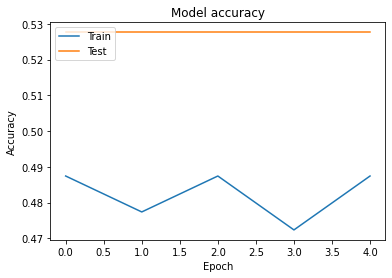

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# **Fine Tuning**

In [ ]:
model.layers[2].trainable = True
output = Dense(2, activation='softmax')(sortie_CLS)
model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-6), metrics=['accuracy'])
model.summary()

Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_4 (TFDisti ((None, 100, 768),)  66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 768)]        0           tf_distil_bert_model_

In [ ]:
MAX_SIZE = 200
history2 = model.fit([output_tokenizer_entrainement['input_ids'][1:MAX_SIZE],output_tokenizer_entrainement['attention_mask'][1:MAX_SIZE]], y_entrainement[1:MAX_SIZE], epochs=5, verbose=1, batch_size = 3, validation_data=([output_tokenizer_tests['input_ids'][1:MAX_SIZE],output_tokenizer_tests['attention_mask'][1:MAX_SIZE]],y_test[1:MAX_SIZE]))

Epoch 1/5
67/67 [==============================] - 6s 95ms/step - loss: 0.4969 - accuracy: 0.8643 - val_loss: 0.5366 - val_accuracy: 0.7487
Epoch 2/5
67/67 [==============================] - 5s 74ms/step - loss: 0.3665 - accuracy: 0.9296 - val_loss: 0.4823 - val_accuracy: 0.7889
Epoch 3/5
67/67 [==============================] - 5s 74ms/step - loss: 0.2745 - accuracy: 0.9648 - val_loss: 0.4590 - val_accuracy: 0.8040
Epoch 4/5
67/67 [==============================] - 5s 76ms/step - loss: 0.2349 - accuracy: 0.9799 - val_loss: 0.4536 - val_accuracy: 0.7940
Epoch 5/5
67/67 [==============================] - 5s 75ms/step - loss: 0.1915 - accuracy: 0.9849 - val_loss: 0.4562 - val_accuracy: 0.7940


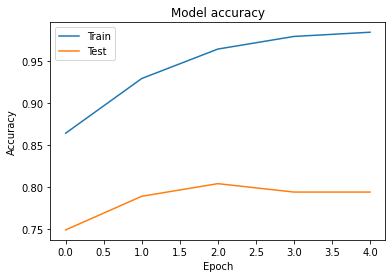

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()